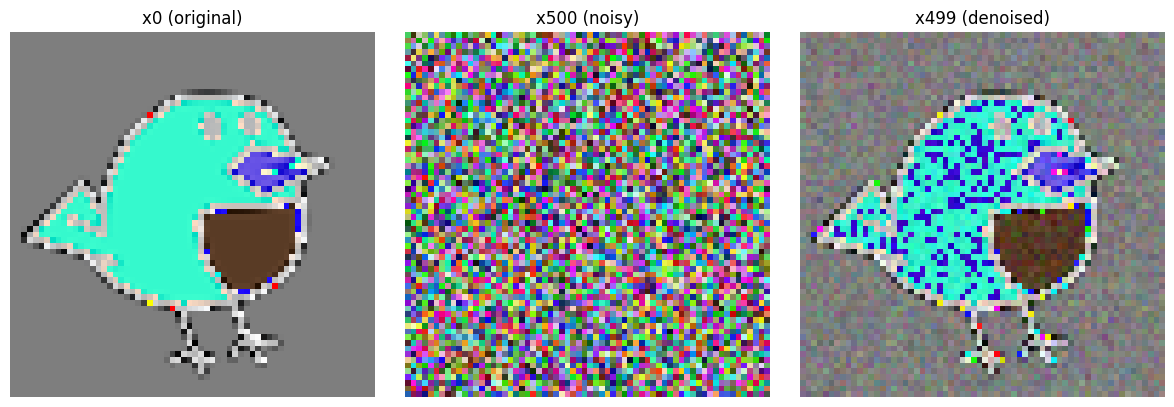

In [2]:
# Reverse Diffusion Process (No Model) - Simulated in Pixel Space

import torch
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, ToPILImage
from PIL import Image
import torchvision.transforms as T
import numpy as np

# 1. Load and normalize image
image = Image.open("images.png").convert("RGB").resize((64, 64))
transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.5], [0.5])  # [-1, 1] range
])
x0 = transform(image).unsqueeze(0)  # shape: [1, 3, H, W]

# 2. Define simple beta schedule
num_timesteps = 1000
betas = torch.linspace(1e-4, 0.02, num_timesteps)
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

# 3. Forward diffusion: generate x_t and save epsilon
T_forward = 500
epsilon = torch.randn_like(x0)
sqrt_alpha_cumprod = alphas_cumprod[T_forward]**0.5
sqrt_one_minus_alpha_cumprod = (1 - alphas_cumprod[T_forward])**0.5
xt = sqrt_alpha_cumprod * x0 + sqrt_one_minus_alpha_cumprod * epsilon

# 4. Reverse diffusion: simulate one-step reverse (x_{t-1})
sqrt_alpha = alphas[T_forward]**0.5
sqrt_one_minus_alpha_bar = (1 - alphas_cumprod[T_forward])**0.5

# Use true epsilon here to simulate perfect model
predicted_x0 = (xt - sqrt_one_minus_alpha_cumprod * epsilon) / sqrt_alpha_cumprod

# Back out x_{t-1}
x_prev = sqrt_alpha * predicted_x0 + torch.sqrt(1 - alphas[T_forward]) * epsilon

# 5. Visualize
inv_transform = T.Compose([
    T.Normalize([0], [2]),
    T.Normalize([-1], [1]),
    ToPILImage()
])

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(inv_transform(x0.squeeze(0)))
axs[0].set_title("x0 (original)")
axs[1].imshow(inv_transform(xt.squeeze(0)))
axs[1].set_title(f"x{T_forward} (noisy)")
axs[2].imshow(inv_transform(x_prev.squeeze(0)))
axs[2].set_title(f"x{T_forward-1} (denoised)")

for ax in axs:
    ax.axis("off")
plt.tight_layout()
plt.show()

In [5]:
from diffusers.schedulers.scheduling_utils import SchedulerMixin
from diffusers.configuration_utils import ConfigMixin

class MyCustomScheduler(SchedulerMixin, ConfigMixin):
    def __init__(self, num_train_timesteps=1000):
        self.num_train_timesteps = num_train_timesteps
        self.betas = self._custom_beta_schedule()
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.init_noise_sigma = 1.0  # required by diffusers

    def _custom_beta_schedule(self):
        """
        Define your own beta schedule.
        This example: cosine-shaped noise schedule.
        """
        steps = torch.arange(self.num_train_timesteps, dtype=torch.float32)
        betas = 0.01 * torch.cos((steps / self.num_train_timesteps) * 3.14159 / 2) ** 2
        return betas.clamp(1e-8, 0.999)

    def add_noise(self, original_samples, noise, timesteps):
        """
        Forward process: x_t = sqrt(a_t) * x_0 + sqrt(1 - a_t) * noise
        """
        device = original_samples.device
        alphas_cumprod = self.alphas_cumprod.to(device)

        sqrt_alpha_prod = alphas_cumprod[timesteps] ** 0.5
        sqrt_one_minus_alpha_prod = (1 - alphas_cumprod[timesteps]) ** 0.5

        # Ensure correct broadcasting over image shape
        while sqrt_alpha_prod.ndim < original_samples.ndim:
            sqrt_alpha_prod = sqrt_alpha_prod.unsqueeze(-1)
            sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.unsqueeze(-1)

        return sqrt_alpha_prod * original_samples + sqrt_one_minus_alpha_prod * noise


    def set_timesteps(self, num_inference_steps):
        """
        Required for compatibility with diffusers pipeline.
        """
        self.timesteps = torch.linspace(0, self.num_train_timesteps - 1, num_inference_steps).long()


/home/albert/miniconda3/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [3]:
def reverse_step(scheduler, xt, eps_pred, t):
    """
    Simulate one reverse step: x_{t-1} = ...
    """
    alpha_t = scheduler.alphas[t].to(xt.device)
    alpha_bar_t = scheduler.alphas_cumprod[t].to(xt.device)

    sqrt_alpha = torch.sqrt(alpha_t)
    sqrt_alpha_bar = torch.sqrt(alpha_bar_t)
    sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bar_t)

    # Estimate x0
    x0_pred = (xt - sqrt_one_minus_alpha_bar * eps_pred) / sqrt_alpha_bar

    # Compute x_{t-1}
    noise = eps_pred  # or re-sample noise here
    xt_prev = sqrt_alpha * x0_pred + torch.sqrt(1 - alpha_t) * noise

    return xt_prev

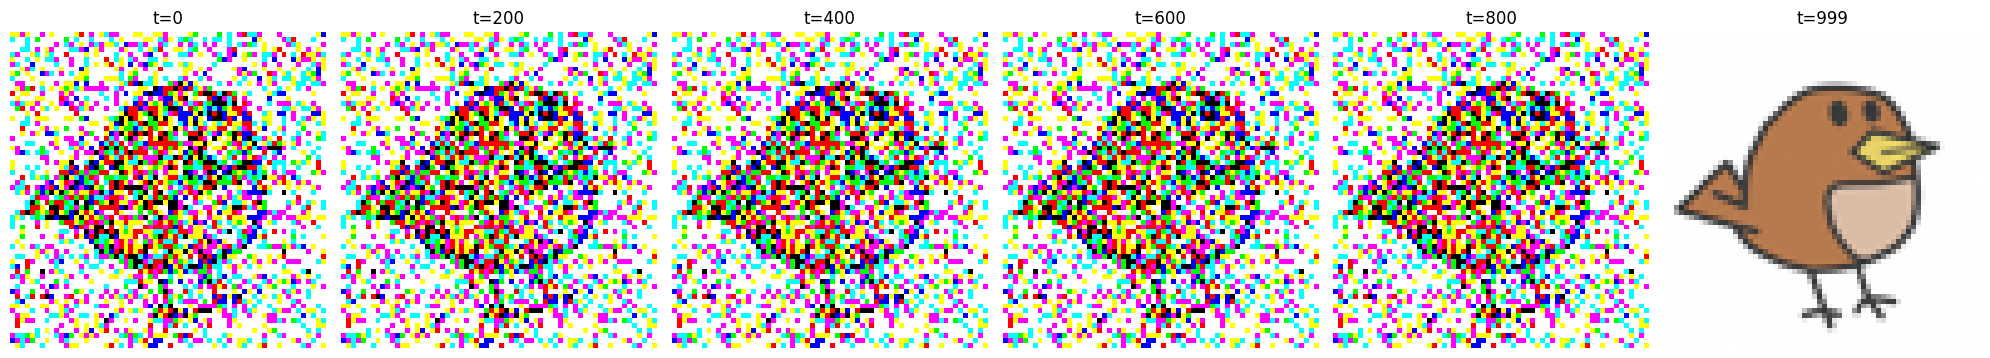

In [19]:
t = 400

image_tensor = x0.squeeze(0).to("cuda")

# x_t = scheduler.add_noise(x0, noise, torch.tensor([num_timesteps - 1], device="cuda"))

# ---- Setup ----
num_timesteps = 1000
save_steps = [999, 800, 600, 400, 200, 0]

scheduler = MyCustomScheduler(num_train_timesteps=num_timesteps)
scheduler.set_timesteps(num_timesteps)

x0 = image_tensor.to("cuda")  # Original image (normalized [-1, 1])
noise = torch.randn_like(x0)

# Simulate forward diffusion to get x_T (very noisy image)
x_t = scheduler.add_noise(x0, noise, torch.tensor([num_timesteps - 1], device="cuda"))
current_xt = x_t.squeeze(0)

# ---- Reverse Diffusion ----
images = []

def reverse_step(scheduler, xt, eps_pred, t):
    alpha_t = scheduler.alphas[t].to(xt.device)
    alpha_bar_t = scheduler.alphas_cumprod[t].to(xt.device)

    sqrt_alpha = torch.sqrt(alpha_t)
    sqrt_alpha_bar = torch.sqrt(alpha_bar_t)
    sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bar_t)

    x0_pred = (xt - sqrt_one_minus_alpha_bar * eps_pred) / sqrt_alpha_bar
    xt_prev = sqrt_alpha * x0_pred + torch.sqrt(1 - alpha_t) * eps_pred
    return xt_prev

# Run denoising loop: from t=999 → 0
for t in reversed(range(num_timesteps)):
    current_xt = reverse_step(scheduler, current_xt, noise.squeeze(0), t)
    if t in save_steps:
        img = (current_xt * 0.5 + 0.5).clamp(0, 1).cpu()
        images.append((img, t))

# ---- Plot in Chronological Order ----
images = sorted(images, key=lambda x: x[1])  # sort by timestep ascending

fig, axs = plt.subplots(1, len(images), figsize=(20, 4))
to_pil = ToPILImage()

for i, (img, t) in enumerate(images):
    axs[i].imshow(to_pil(img))
    axs[i].set_title(f"t={t}")
    axs[i].axis("off")

plt.tight_layout()
plt.show()
